# Rank all 18 615 protein-coding genes based on ability to distinguish dysplastic from non-cancerous tissue

In [1]:
data_directory_path="./data"
model_directory_path="./resources"
args_dict = {
    "file_name_scRNAseq": 'Crunch3_scRNAseq.h5ad',  # Filename for scRNAseq data
    "filter_column_scRNAseq": "dysplasia",  # Column for filtering scRNAseq data
    "filter_value_no_cancer": "n",  # Filtered column value indicating absence of cancer
    "filter_value_cancer": "y",  # Filtered column value indicating the presence of cancer
    "column_for_ranking": "abs_logFC",
    "ascending": False
}

In [2]:
from types import SimpleNamespace
args = SimpleNamespace(**args_dict)

In [3]:
import spatialdata as sd 
import os
sdata = sd.read_zarr(os.path.join(data_directory_path, 'UC9_I.zarr'))
gene_460_names = list(sdata["anucleus"].var.index)

dysplasia_file = {
    # H&E image of tissue with dysplasia
    'tif_HE': os.path.join(data_directory_path, 'UC9_I-crunch3-HE.tif'),

    # Nucleus segmentation of H&E image
    'tif_HE_nuc': os.path.join(data_directory_path, 'UC9_I-crunch3-HE-label-stardist.tif'),

    # Regions in H&E image highlighting dysplasia and non-dysplasia
    'tif_region': os.path.join(data_directory_path, 'UC9_I-crunch3-HE-dysplasia-ROI.tif')
}

/usr/lib/python3.10/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


In [4]:
import skimage.io
# Read the dysplasia-related images and store them in a dictionary
dysplasia_img_list = {}
for key in dysplasia_file:
    dysplasia_img_list[key] = skimage.io.imread(dysplasia_file[key])

In [5]:
from skimage.measure import regionprops
regions = regionprops(dysplasia_img_list['tif_HE_nuc'])

In [6]:
from tqdm import tqdm
# Divide cell IDs between dysplasia and non-dysplasia status
cell_ids_no_cancer, cell_ids_cancer = [], []
# Loop through each region and extract centroid if the cell ID matches
for props in tqdm(regions):
    cell_id = props.label
    centroid = props.centroid
    y_center, x_center = int(centroid[0]), int(centroid[1])
    # Using UC9_I-crunch3-HE-dysplasia-ROI.tif, check if cell ID highlight dysplasia or non-dysplasia (or 0 indicating other tissue regions)
    dysplasia = dysplasia_img_list['tif_region'][y_center, x_center]
    if dysplasia == 1:
        cell_ids_no_cancer.append(cell_id)
    elif dysplasia == 2:
        cell_ids_cancer.append(cell_id)

100%|████████████████████████████████| 460243/460243 [00:16<00:00, 27426.76it/s]


In [65]:
len(cell_ids_cancer), len(cell_ids_no_cancer)

(45712, 90491)

In [7]:
from infer_crunch_1 import infer_crunch_1

prediction_cell_ids_no_cancer1 = infer_crunch_1(
    name_data="UC9_I no cancer",
    data_file_path=data_directory_path,
    model_directory_path=model_directory_path,
    sdata=dysplasia_img_list,
    cell_ids=cell_ids_no_cancer,
    gene_460_names=gene_460_names
)

prediction_cell_ids_cancer1 = infer_crunch_1(
    name_data="UC9_I cancer",
    data_file_path=data_directory_path,
    model_directory_path=model_directory_path,
    sdata=dysplasia_img_list,
    cell_ids=cell_ids_cancer,
    gene_460_names=gene_460_names
)


-- UC9_I no cancer INFERENCE ---------------------------------------------------------------


** UC9_I no cancer Predict the expression of 460 genes (Crunch 1) ****************************************************************


--UC9_I no cancer EMBEDDING--

Embedding images using resnet50 encoder
Load pretrained Resnet50 offline from weights path: ./resources/pytorch_model.bin
Skipping embedding UC9_I no cancer.h5 as it already exists
Embedding shape (X_test): (90491, 1024)

--UC9_I no cancer REGRESSION PREDICTIONS--

Loaded model from ./resources/ST_pred_results/split1/model.pkl
Loaded model from ./resources/ST_pred_results/split0/model.pkl

 Predictions shape: (90491, 460)

-- UC9_I cancer INFERENCE ---------------------------------------------------------------


** UC9_I cancer Predict the expression of 460 genes (Crunch 1) ****************************************************************


--UC9_I cancer EMBEDDING--

Embedding images using resnet50 encoder
Load pretrained Resnet5

In [8]:
import scanpy as sc 
scRNAseq = sc.read_h5ad(os.path.join(data_directory_path, args.file_name_scRNAseq))

In [9]:
# Filter scRNAseq data by dysplasia status
scRNAseq_no_cancer = scRNAseq[scRNAseq.obs[args.filter_column_scRNAseq] == args.filter_value_no_cancer].copy()
scRNAseq_cancer = scRNAseq[scRNAseq.obs[args.filter_column_scRNAseq] == args.filter_value_cancer].copy()
del scRNAseq

In [10]:
from infer_crunch_2 import infer_crunch_2

In [12]:
subsample = 5000
len(prediction_cell_ids_no_cancer1), len(prediction_cell_ids_cancer1)

(90491, 45712)

In [13]:
# No cancer status: predict the expression of 18157 genes using the expression of the 460 inferred genes and scRNAseq data (Crunch 2)
prediction_cell_ids_no_cancer2 = infer_crunch_2(
    prediction_460_genes=prediction_cell_ids_no_cancer1[0:subsample],
    name_data="UC9_I no cancer",
    data_file_path=data_directory_path,
    model_directory_path=model_directory_path,
    scRNAseq=scRNAseq_no_cancer,
    filter_column=args.filter_column_scRNAseq,
    filter_value=args.filter_value_no_cancer
)


** UC9_I no cancer Predict the expression of 18157 unmeasured genes (Crunch 2) ****************************************************************

--COSINE SIMILARITIES between UC9_I no cancer and single-cell RNA sequencing from shared genes--

Number of shared genes between scRNA-seq and xenium data: 458
Number of unmeasured genes in Xenium data: 18157 

scRNA-Seq data shape (45482 samples x 18615 shared genes + unmeasured genes)
Xenium data shape (5000 samples x 458 shared genes)

Compute COSINE SIMILARITY: Find the top_k(=30) similar scRNA-Seq cells for each Xenium cell...

Compute WEIGHTED AVERAGE of unmeasured genes from scRNA-Seq based on similarity scores...

-- UC9_I no cancer PREDICTION DONE --



In [14]:
# Cancer status: predict the expression of 18157 genes using the expression of the 460 inferred genes and scRNAseq data (Crunch 2)
prediction_cell_ids_cancer2 = infer_crunch_2(
    prediction_460_genes=prediction_cell_ids_cancer1[0:subsample],
    name_data="UC9_I cancer",
    data_file_path=data_directory_path,
    model_directory_path=model_directory_path,
    scRNAseq=scRNAseq_cancer,
    filter_column=args.filter_column_scRNAseq,
    filter_value=args.filter_value_cancer
)


** UC9_I cancer Predict the expression of 18157 unmeasured genes (Crunch 2) ****************************************************************

--COSINE SIMILARITIES between UC9_I cancer and single-cell RNA sequencing from shared genes--

Number of shared genes between scRNA-seq and xenium data: 458
Number of unmeasured genes in Xenium data: 18157 

scRNA-Seq data shape (91811 samples x 18615 shared genes + unmeasured genes)
Xenium data shape (5000 samples x 458 shared genes)

Compute COSINE SIMILARITY: Find the top_k(=30) similar scRNA-Seq cells for each Xenium cell...

Compute WEIGHTED AVERAGE of unmeasured genes from scRNA-Seq based on similarity scores...

-- UC9_I cancer PREDICTION DONE --



In [15]:
from gene_ranking import gene_ranking

In [24]:
prediction, df_gene_ranking = gene_ranking(prediction_cell_ids_no_cancer2, prediction_cell_ids_cancer2,
                               column_for_ranking=args.column_for_ranking, ascending=args.ascending)

Gene ranking by abs_logFC:


,mean_no_cancer,mean_cancer,variance_no_cancer,variance_cancer,dif_abs_mean,logFC,abs_logFC
COMP,0.137522,0.000000,0.035501,0.000000,0.137522,-17.069313,17.069313
EBF2,0.109462,0.000000,0.031758,0.000000,0.109462,-16.740084,16.740084
F12,0.000000,0.074202,0.000000,0.002904,0.074202,16.179190,16.179190
S100A2,0.000000,0.070616,0.000000,0.002792,0.070616,16.107728,16.107728
ISLR,0.067188,0.000000,0.006408,0.000000,0.067188,-16.035937,16.035937
...,...,...,...,...,...,...,...
TREML2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TREML4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IGKV1-33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TREX1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
# Save the ranked genes to a CSV file -> to use for the inder function and crunchDAO crunch 3 submission
prediction.to_csv(os.path.join(model_directory_path, "gene_ranking.csv"))

In [26]:
prediction

,Gene Name
1,COMP
2,EBF2
3,F12
4,S100A2
5,ISLR
...,...
18611,TREML2
18612,TREML4
18613,IGKV1-33
18614,TREX1


## Infer function

The `infer` function loads the gene ranking CSV file and and returns it as the output.

In [27]:
import pandas as pd
def infer(
    data_file_path: str,
    data_directory_path: str,
    model_directory_path: str
):
    return pd.read_csv(os.path.join(model_directory_path, "gene_ranking.csv"), index_col=0)

prediction = infer(
    data_file_path="./data",
    data_directory_path="./data",
    model_directory_path="./resources"
)

prediction

,Gene Name
1,COMP
2,EBF2
3,F12
4,S100A2
5,ISLR
...,...
18611,TREML2
18612,TREML4
18613,IGKV1-33
18614,TREX1


## Insight

In [28]:
df_gene_ranking

,mean_no_cancer,mean_cancer,variance_no_cancer,variance_cancer,dif_abs_mean,logFC,abs_logFC
COMP,0.137522,0.000000,0.035501,0.000000,0.137522,-17.069313,17.069313
EBF2,0.109462,0.000000,0.031758,0.000000,0.109462,-16.740084,16.740084
F12,0.000000,0.074202,0.000000,0.002904,0.074202,16.179190,16.179190
S100A2,0.000000,0.070616,0.000000,0.002792,0.070616,16.107728,16.107728
ISLR,0.067188,0.000000,0.006408,0.000000,0.067188,-16.035937,16.035937
...,...,...,...,...,...,...,...
TREML2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TREML4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IGKV1-33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TREX1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
'COMP' in gene_460_names

False

In [39]:
prediction['is460'] = prediction['Gene Name'].apply(lambda x: x in gene_460_names)

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_gene_ranking[['logFC']].copy()

df['is460'] = ['green' if gene in gene_460_names else 'red' for gene in df.index]

In [54]:
df['rank'] = [i+1 for i in range(len(df))]

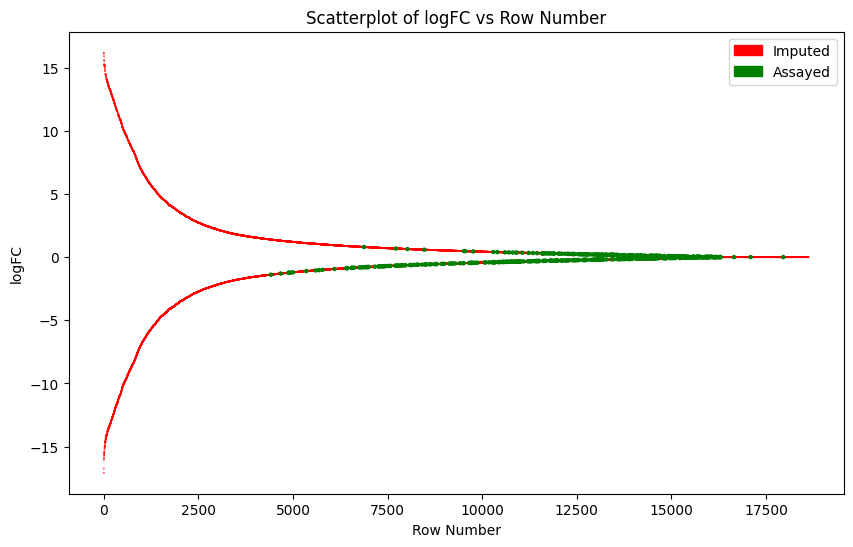

In [64]:
# Create the scatterplot
plt.figure(figsize=(10, 6))
df_460 = df[df.is460 == 'green']
df_imputed = df[df.is460 != 'green']
plt.scatter(df_imputed['rank'].values, df_imputed['logFC'].values, c=df_imputed['is460'].values, s=0.1);
plt.scatter(df_460['rank'].values, df_460['logFC'].values, c=df_460['is460'].values, s=5);

# Add labels and title
plt.xlabel('Row Number')
plt.ylabel('logFC')
plt.title('Scatterplot of logFC vs Row Number')

# Create custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Imputed')
green_patch = mpatches.Patch(color='green', label='Assayed')
plt.legend(handles=[red_patch, green_patch]);